<a href="https://colab.research.google.com/github/2018007956/HYU/blob/main/Deep_Learning%5C5_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Overfitting
2. L1 L2 Regularization
3. Dropout
4. Normalization

# 1. Overfitting
학습데이터에 대해 과하게 학습하여 실제 데이터에 대한 오차가 증가할 경우 발생  
Sol) Training data 늘림, Regularization, Dropout

# 2. L1 L2 Regularization
모델 파라미터 확인: named_parameters() or parameters()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

class LogisticRegression(nn.Module):
  def __init__(self, x_in, x_out):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(x_in, x_out)
    self.activation = nn.Sigmoid()
  def forward(self, x):
    z = self.linear(x)
    a = self.activation(z)
    return a

model = LogisticRegression(2, 1)

In [3]:
for name, param in model.named_parameters():
  print('========================')
  print(name)
  print(param.shape)
  print(param)

linear.weight
torch.Size([1, 2])
Parameter containing:
tensor([[-0.3816, -0.6748]], requires_grad=True)
linear.bias
torch.Size([1])
Parameter containing:
tensor([0.1560], requires_grad=True)


## L1 loss in LogisticRegression
reg = model.linear.weight.abs().sum()

In [4]:
print(model.linear.weight)
print(model.linear.weight.abs().sum())

Parameter containing:
tensor([[-0.3816, -0.6748]], requires_grad=True)
tensor(1.0564, grad_fn=<SumBackward0>)


## L2 loss in LogisticRegression
reg = model.linear.weight.pow(2.0).sum()

In [5]:
print(model.linear.weight)
print(model.linear.weight.pow(2.0).sum())

Parameter containing:
tensor([[-0.3816, -0.6748]], requires_grad=True)
tensor(0.6010, grad_fn=<SumBackward0>)


## Random Seed 고정
- 모델 weight가 생성될 때마다 random하게 생성됨
- 성능 비교를 하기위해 값을 고정하는게 좋다
  - 어떤 random한 값에서는 좋게 나오고 다른 값에서는 나쁘게 나올 수 있음

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [7]:
print(model.linear.weight[0,1])

tensor(-0.6748, grad_fn=<SelectBackward0>)


## Cifar-10
RGB Images, Class 10  
Size: 32 * 32 * 3  
Training:Test = 50000:10000

In [8]:
import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting CIFAR10/cifar-10-python.tar.gz to CIFAR10/
Files already downloaded and verified


## Model Structure
Input size: 32 * 32 * 3  
Output size: 10

In [9]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [10]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [20]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(32*32*3, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 10)

    self.activation = nn.Sigmoid()

  def forward(self, x):
    z1 = self.linear1(x)
    a1 = self.activation(z1)

    z2 = self.linear2(a1)
    a2 = self.activation(z2)

    z3 = self.linear3(a2)

    return z3

In [21]:
model = Model().to(device).train()

In [22]:
optimizer = optim.SGD(model.parameters(), lr=1)

In [14]:
criterion = nn.CrossEntropyLoss()

- 실제로 학습이 overfitting인지 확인  
  - Matplotlib 활용
  - detach(): 기존 텐서 복사
  - cpu(): GPU에 있는 tensor CPU로 이동

In [25]:
epochs = 30
lmbd = 0.003

train_avg_costs = []
test_avg_costs = []

test_total_batch = len(test_dataloader)
total_batch_num = len(train_dataloader)

for epoch in range(epochs):
  avg_cost = 0
  model.train()
  for b_x, b_y in train_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    logits = model(b_x) # forward propagation
    loss = criterion(logits, b_y.to(device)) # get cost

    # L2 Regularization
    reg = model.linear1.weight.pow(2.0).sum()
    reg += model.linear2.weight.pow(2.0).sum()
    reg += model.linear3.weight.pow(2.0).sum()
    loss += lmbd*reg/len(b_x)/2.

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters

    avg_cost += loss/total_batch_num
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  model.eval()
  for b_x, b_y in test_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    with torch.no_grad():
      logits = model(b_x)
      test_loss = criterion(logits, b_y.to(device)) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())

Epoch : 1 / 30, cost: 1.2776256799697876
Epoch : 2 / 30, cost: 1.2607420682907104
Epoch : 3 / 30, cost: 1.2506444454193115
Epoch : 4 / 30, cost: 1.2461702823638916
Epoch : 5 / 30, cost: 1.2413525581359863
Epoch : 6 / 30, cost: 1.2354445457458496
Epoch : 7 / 30, cost: 1.2342416048049927
Epoch : 8 / 30, cost: 1.2128193378448486
Epoch : 9 / 30, cost: 1.220913052558899
Epoch : 10 / 30, cost: 1.215277075767517
Epoch : 11 / 30, cost: 1.2067861557006836
Epoch : 12 / 30, cost: 1.1988952159881592
Epoch : 13 / 30, cost: 1.2049226760864258
Epoch : 14 / 30, cost: 1.1912301778793335
Epoch : 15 / 30, cost: 1.1882240772247314
Epoch : 16 / 30, cost: 1.1795523166656494
Epoch : 17 / 30, cost: 1.159223198890686
Epoch : 18 / 30, cost: 1.1694755554199219
Epoch : 19 / 30, cost: 1.1600922346115112
Epoch : 20 / 30, cost: 1.1595392227172852
Epoch : 21 / 30, cost: 1.1587382555007935
Epoch : 22 / 30, cost: 1.1456007957458496
Epoch : 23 / 30, cost: 1.1501083374023438
Epoch : 24 / 30, cost: 1.1382532119750977
Epoc

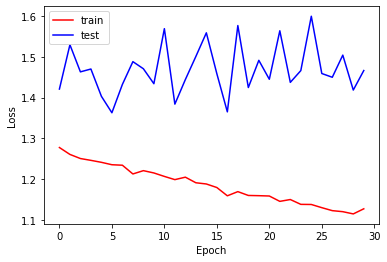

In [27]:
import matplotlib.pyplot as plt
import numpy as np
epoch = range(epochs)
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [39]:
# Test set accuracy
# from sklearn.metrics import accuracy_score
sum(test_avg_costs)/len(test_dataloader)

tensor(0.5577)

#3. Dropout

In [40]:
class Model(nn.Module):
  def __init__(self, drop_prob):
    super(Model, self).__init__()
    self.linear1 = nn.Linear(32*32*3, 256)
    self.linear2 = nn.Linear(256, 128)
    self.linear3 = nn.Linear(128, 10)

    self.dropout = nn.Dropout(drop_prob)
    self.activation = nn.Sigmoid()

  def forward(self, x):
    z1 = self.linear1(x)
    a1 = self.activation(z1)
    a1 = self.dropout(a1)

    z2 = self.linear2(a1)
    a2 = self.activation(z2)
    a2 = self.dropout(a2)

    z3 = self.linear3(a2)

    return z3

In [41]:
model = Model(0.1).to(device).train()

In [42]:
epochs = 20
lmbd = 0.003

train_avg_costs = []
test_avg_costs = []

test_total_batch = len(test_dataloader)
total_batch_num = len(train_dataloader)

for epoch in range(epochs):
  avg_cost = 0
  model.train()
  for b_x, b_y in train_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    logits = model(b_x) # forward propagation
    loss = criterion(logits, b_y.to(device)) # get cost

    # L2 Regularization
    reg = model.linear1.weight.pow(2.0).sum()
    reg += model.linear2.weight.pow(2.0).sum()
    reg += model.linear3.weight.pow(2.0).sum()
    loss += lmbd*reg/len(b_x)/2.

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters

    avg_cost += loss/total_batch_num
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  model.eval()
  for b_x, b_y in test_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    with torch.no_grad():
      logits = model(b_x)
      test_loss = criterion(logits, b_y.to(device)) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())

Epoch : 1 / 20, cost: 2.37669038772583
Epoch : 2 / 20, cost: 2.376309394836426
Epoch : 3 / 20, cost: 2.3765299320220947
Epoch : 4 / 20, cost: 2.3770196437835693
Epoch : 5 / 20, cost: 2.376555919647217
Epoch : 6 / 20, cost: 2.37602162361145
Epoch : 7 / 20, cost: 2.3762996196746826
Epoch : 8 / 20, cost: 2.37703800201416
Epoch : 9 / 20, cost: 2.3776655197143555
Epoch : 10 / 20, cost: 2.376386880874634
Epoch : 11 / 20, cost: 2.3764779567718506
Epoch : 12 / 20, cost: 2.37656307220459
Epoch : 13 / 20, cost: 2.376694679260254
Epoch : 14 / 20, cost: 2.3763818740844727
Epoch : 15 / 20, cost: 2.3767223358154297
Epoch : 16 / 20, cost: 2.3763954639434814
Epoch : 17 / 20, cost: 2.377157688140869
Epoch : 18 / 20, cost: 2.376375436782837
Epoch : 19 / 20, cost: 2.376584768295288
Epoch : 20 / 20, cost: 2.377328395843506


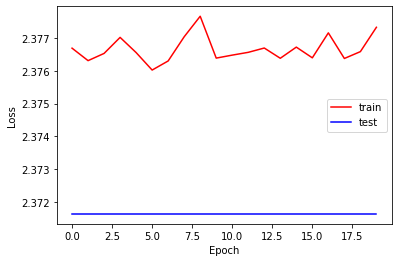

In [43]:
import matplotlib.pyplot as plt
import numpy as np
epoch = range(epochs)
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [44]:
test_avg_costs

tensor(0.6004)

#4. Normalization

In [45]:
import torchvision
import torchvision.transforms as train

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]
)

train_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
test_dataset = torchvision.datasets.CIFAR10(root='CIFAR10/',
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)

Files already downloaded and verified
Files already downloaded and verified


In [47]:
model = Model(0.1).to(device).train()

In [48]:
epochs = 20
lmbd = 0.003

train_avg_costs = []
test_avg_costs = []

test_total_batch = len(test_dataloader)
total_batch_num = len(train_dataloader)

for epoch in range(epochs):
  avg_cost = 0
  model.train()
  for b_x, b_y in train_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    logits = model(b_x) # forward propagation
    loss = criterion(logits, b_y.to(device)) # get cost

    # L2 Regularization
    reg = model.linear1.weight.pow(2.0).sum()
    reg += model.linear2.weight.pow(2.0).sum()
    reg += model.linear3.weight.pow(2.0).sum()
    loss += lmbd*reg/len(b_x)/2.

    optimizer.zero_grad()
    loss.backward() # backward propagation
    optimizer.step() # update parameters

    avg_cost += loss/total_batch_num
  train_avg_costs.append(avg_cost.detach().cpu())
  print('Epoch : {} / {}, cost: {}'.format(epoch+1, epochs, avg_cost))

  test_avg_cost=0
  model.eval()
  for b_x, b_y in test_dataloader:
    b_x = b_x.view(-1, 32*32*3).to(device)
    with torch.no_grad():
      logits = model(b_x)
      test_loss = criterion(logits, b_y.to(device)) # get cost 
    test_avg_cost += test_loss / test_total_batch 

  test_avg_costs.append(test_avg_cost.detach().cpu())

Epoch : 1 / 20, cost: 2.349885940551758
Epoch : 2 / 20, cost: 2.3506252765655518
Epoch : 3 / 20, cost: 2.3505702018737793
Epoch : 4 / 20, cost: 2.349616527557373
Epoch : 5 / 20, cost: 2.349648952484131
Epoch : 6 / 20, cost: 2.3497121334075928
Epoch : 7 / 20, cost: 2.3497250080108643
Epoch : 8 / 20, cost: 2.3496391773223877
Epoch : 9 / 20, cost: 2.3499512672424316
Epoch : 10 / 20, cost: 2.3501293659210205
Epoch : 11 / 20, cost: 2.3495936393737793
Epoch : 12 / 20, cost: 2.349809408187866
Epoch : 13 / 20, cost: 2.3496360778808594
Epoch : 14 / 20, cost: 2.3496079444885254
Epoch : 15 / 20, cost: 2.3500285148620605
Epoch : 16 / 20, cost: 2.3501060009002686
Epoch : 17 / 20, cost: 2.349703788757324
Epoch : 18 / 20, cost: 2.3499538898468018
Epoch : 19 / 20, cost: 2.3502907752990723
Epoch : 20 / 20, cost: 2.3499515056610107


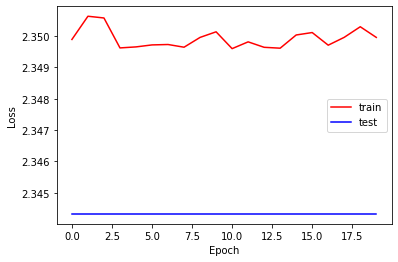

In [49]:
import matplotlib.pyplot as plt
import numpy as np
epoch = range(epochs)
plt.plot(epoch, train_avg_costs, 'r-')
plt.plot(epoch, test_avg_costs, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

In [50]:
sum(test_avg_costs)/len(test_dataloader)

tensor(0.5935)